In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

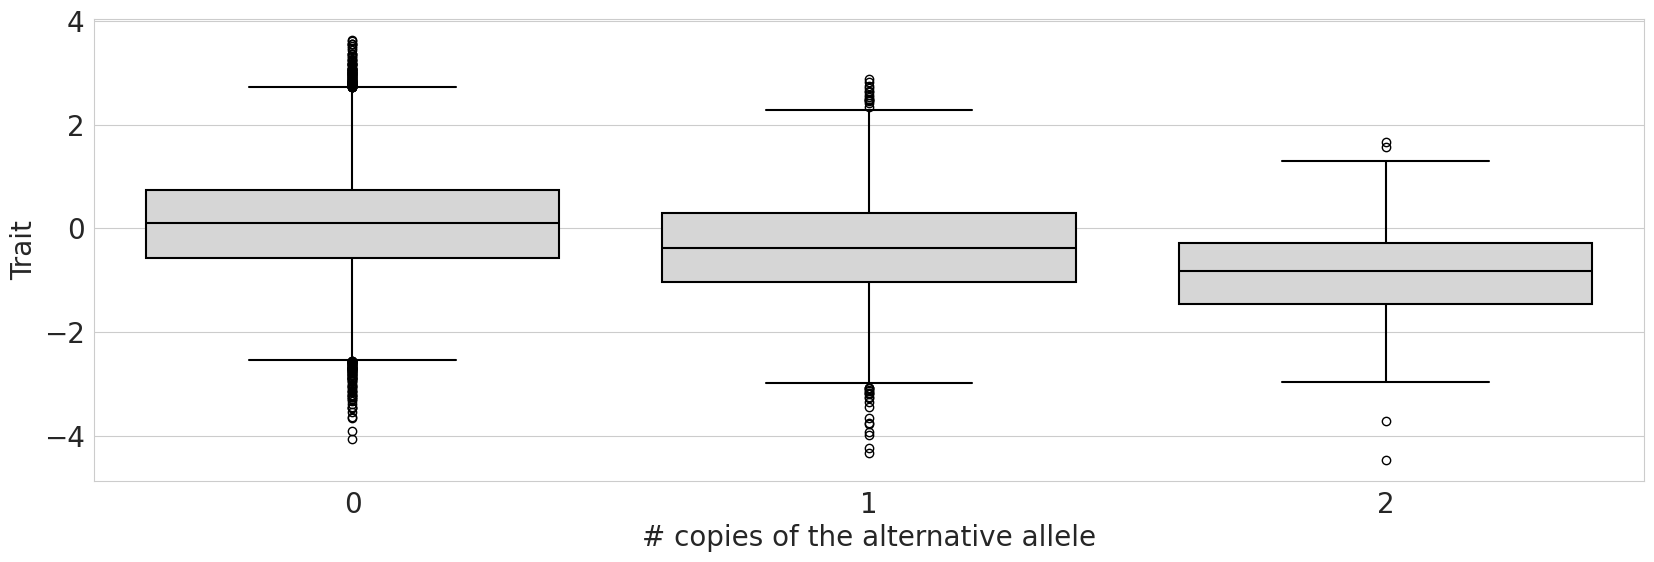

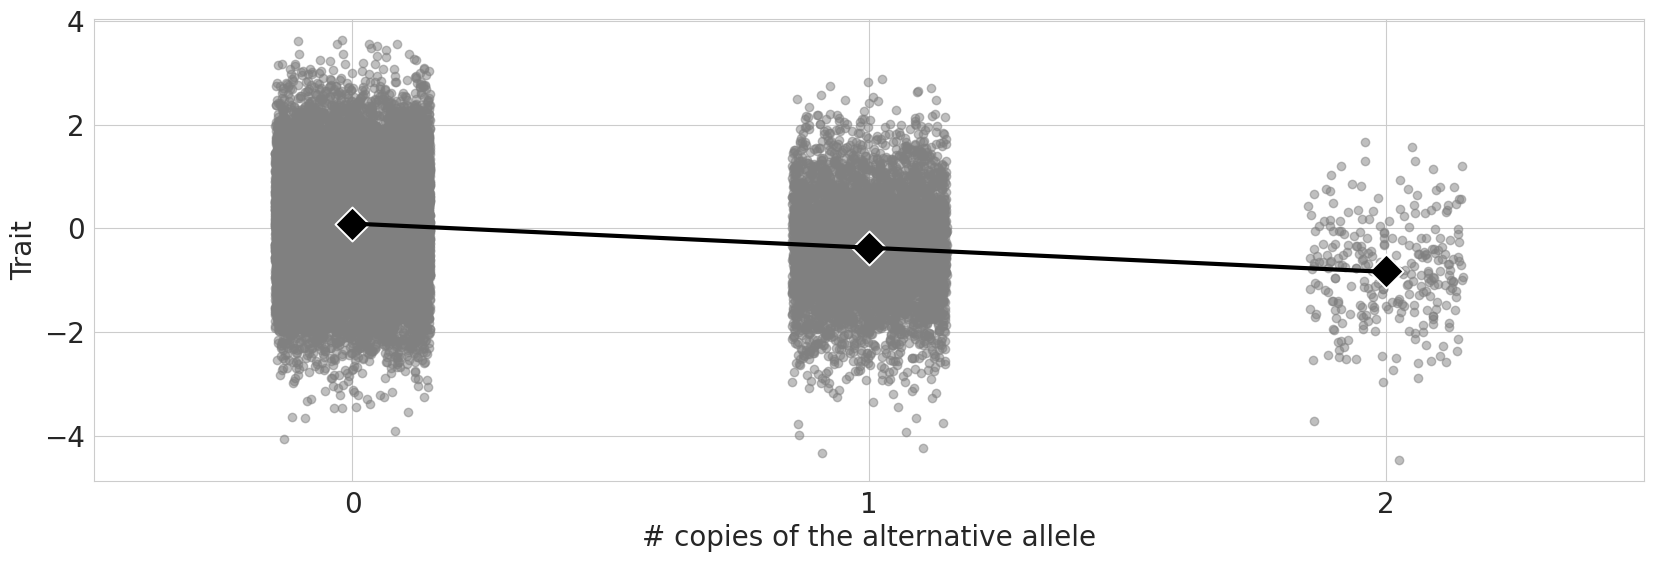

In [2]:
def z_score(x):
    return (x - x.mean()) / x.std()

np.random.seed(1)

MAF = .1
N = 30_000
beta = -.2

p = 1 - MAF
q = MAF
G = np.random.choice(
    [0, 1, 2],
    size=(N, ),
    p=[p ** 2, 2 * p * q, q ** 2],
)

# beta = np.ones_like(G) * beta + np.random.normal(0, .1, (N, )) * G
y = z_score(G) * beta + np.random.normal(0, 1, (N, ))
y = z_score(y)

df = pd.DataFrame({'G': G, 'y': y})

with sns.axes_style("whitegrid"):
    figsize = (20, 6)
    plt.figure(figsize=figsize)
    plt.rcParams.update({'font.size': 20})

    palette = {
        0: '#e5e5e5',
        1: '#b7d3e5',
        2: '#2d9fe5',
    }
    sns.boxplot(
        x=G,
        y=y,
#         palette=palette,
        color='#d6d6d6',
        linecolor='black',
        linewidth=1.5,
    )
    plt.ylabel('Trait')
    plt.xlabel('# copies of the alternative allele')

    plt.figure(figsize=figsize)
    sns.regplot(
        x=G,
        y=y,
        color='gray',
        line_kws={
            'color': 'black', 
            'lw': 3,
        },
        scatter_kws={'alpha': .5},
        x_jitter=.15,
        ci=None,
    )
    sns.scatterplot(
        x=[0, 1, 2],
        y=df.groupby('G')['y'].mean(),
        marker='D',
        color='black',
        s=300,
    )
    plt.xlim(-.5, 2.5)
    plt.xticks([0, 1, 2])
    plt.ylabel('Trait')
    plt.xlabel('# copies of the alternative allele')

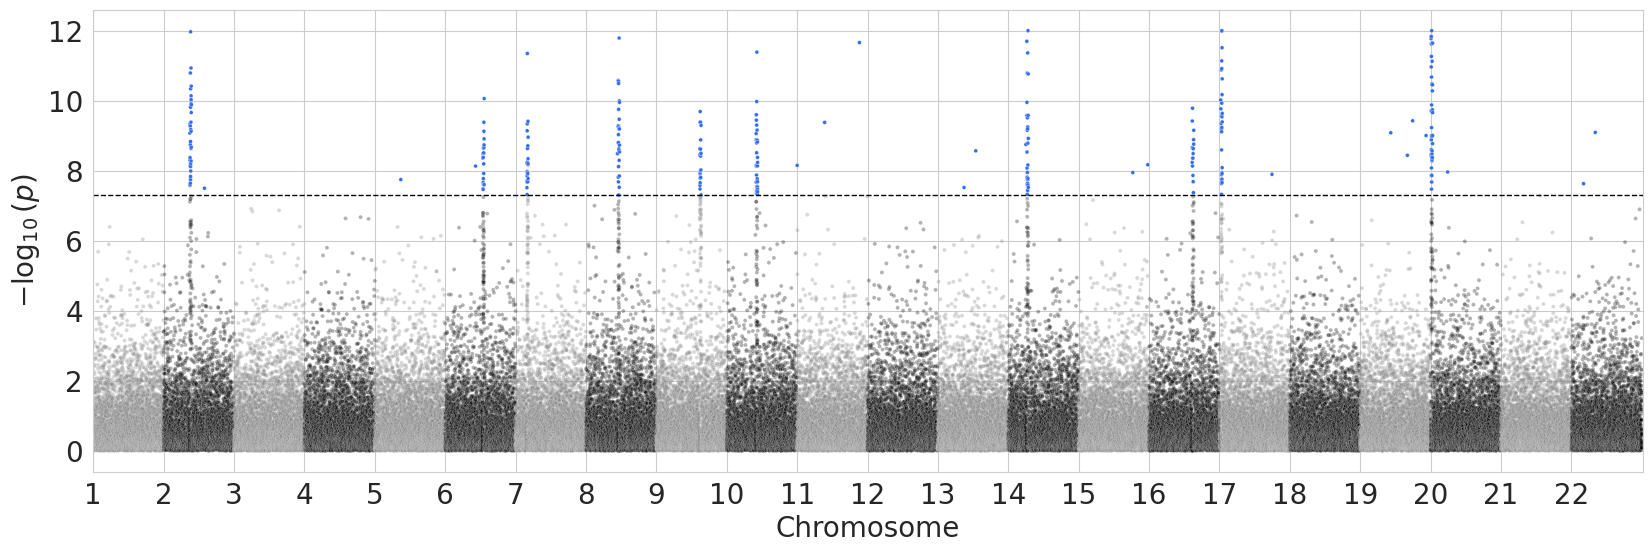

In [7]:
def generate_fake_gwas_data(n_snps=100000, n_chromosomes=22, n_causal=10):
    """Generate fake GWAS data with random SNP positions and p-values."""
    data = []
    chrom_offsets = np.cumsum([0] + [1_000_000_000] * (n_chromosomes - 1))  # Spacing chromosomes evenly
    for chrom in range(1, n_chromosomes + 1):
        snps_per_chrom = n_snps // n_chromosomes
        positions = np.sort(np.random.randint(1, 1_000_000_000, size=snps_per_chrom)) + chrom_offsets[chrom - 1]
        p_values = np.random.uniform(0, 1, size=snps_per_chrom) ** 2  # Bias towards small p-values
        data.append(pd.DataFrame({
            'chromosome': chrom,
            'position': positions,
            '-log10p': -np.log10(p_values)
        }))
    df = pd.concat(data).reset_index()
    df['causal'] = False
    
    
    idxs_causal = np.random.choice(np.arange(len(df)), n_causal)
    n_neighbors = 50
    for idx in idxs_causal:
        val = np.random.randint(8, 12)
        df.at[idx, '-log10p'] = val
        df.at[idx, 'causal'] = True
        for offset in np.arange(-n_neighbors, n_neighbors):
            df.at[idx + offset, '-log10p'] = np.random.randint(1, val + 1) + np.random.normal(0,1)
    df['-log10p'].clip(lower=0, upper=12, inplace=True)
    
    return df.fillna(0)

def plot_manhattan(df):
    """Plot a Manhattan plot from GWAS data."""
    plt.figure(figsize=figsize)
    colors = [
        'black',
        'gray',
        '#326eef',
#         '#f26a7a',
    ]  # Alternating colors for chromosomes and significant SNPs
    df['color'] = df.apply(
        lambda row: colors[int(row['chromosome'] % 2 if row['-log10p'] < -np.log10(5e-8) else 2)],
        axis=1,
    )
    alpha = 0.3
    df['alpha'] = df.apply(
        lambda row: alpha if row['-log10p'] < -np.log10(5e-8) else 1,
        axis=1,
    )
    
    xlabel_ticks = []
    for chrom in df['chromosome'].unique():
        chrom_data = df[df['chromosome'] == chrom]
        sns.scatterplot(
            x=chrom_data['position'],
            y=chrom_data['-log10p'], 
            c=chrom_data['color'], 
            alpha=chrom_data['alpha'],
            s=8,
        )
        
        xlabel_ticks.append(chrom_data['position'].min())
    
    x_offset = 10000000
    plt.xlim(df['position'].min() - x_offset, df['position'].max() + x_offset)
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1, label='Genome-wide significance')
    plt.xticks(ticks=xlabel_ticks, labels=range(1, df['chromosome'].nunique() + 1))
    plt.xlabel('Chromosome')
    plt.ylabel('$-\log_{10}(p)$')
    plt.show()


np.random.seed(2)
df_fake = generate_fake_gwas_data()
with sns.axes_style("whitegrid"):
    plot_manhattan(df_fake)

### LD and GWAS illustration

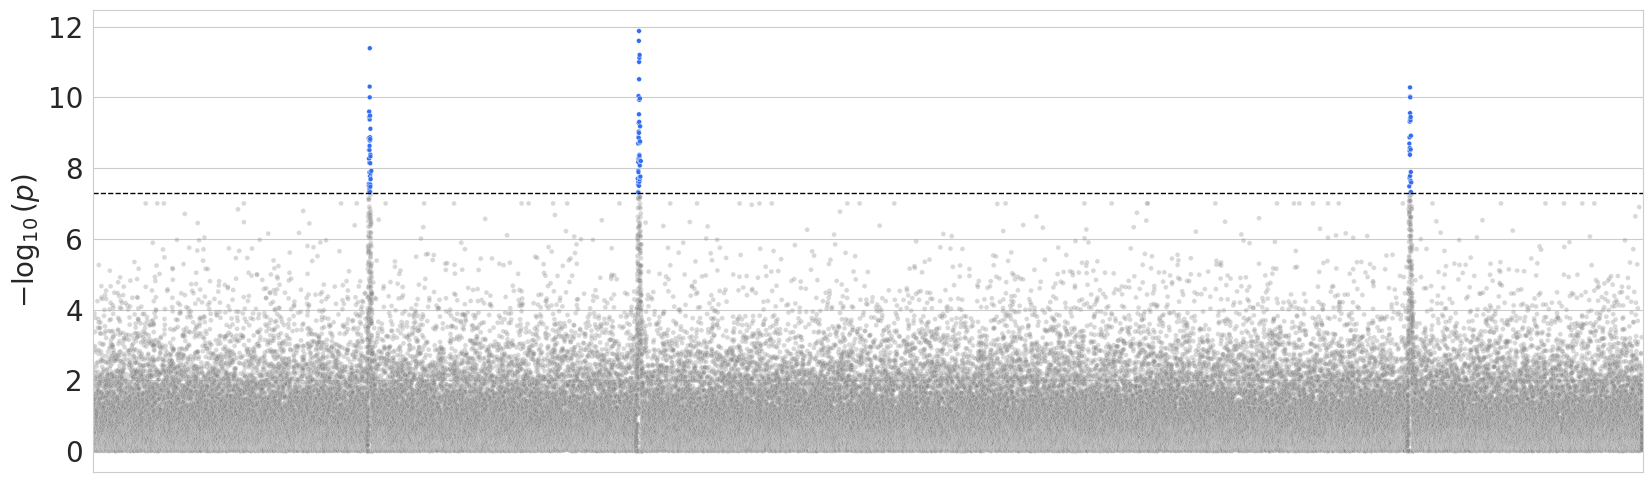

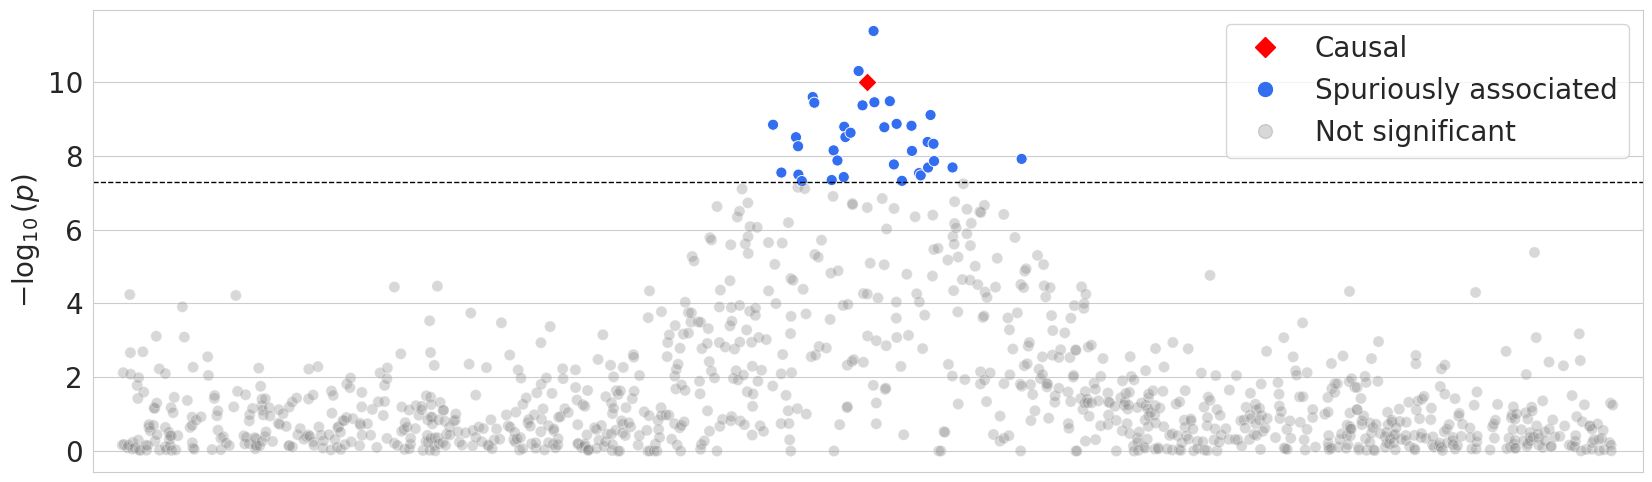

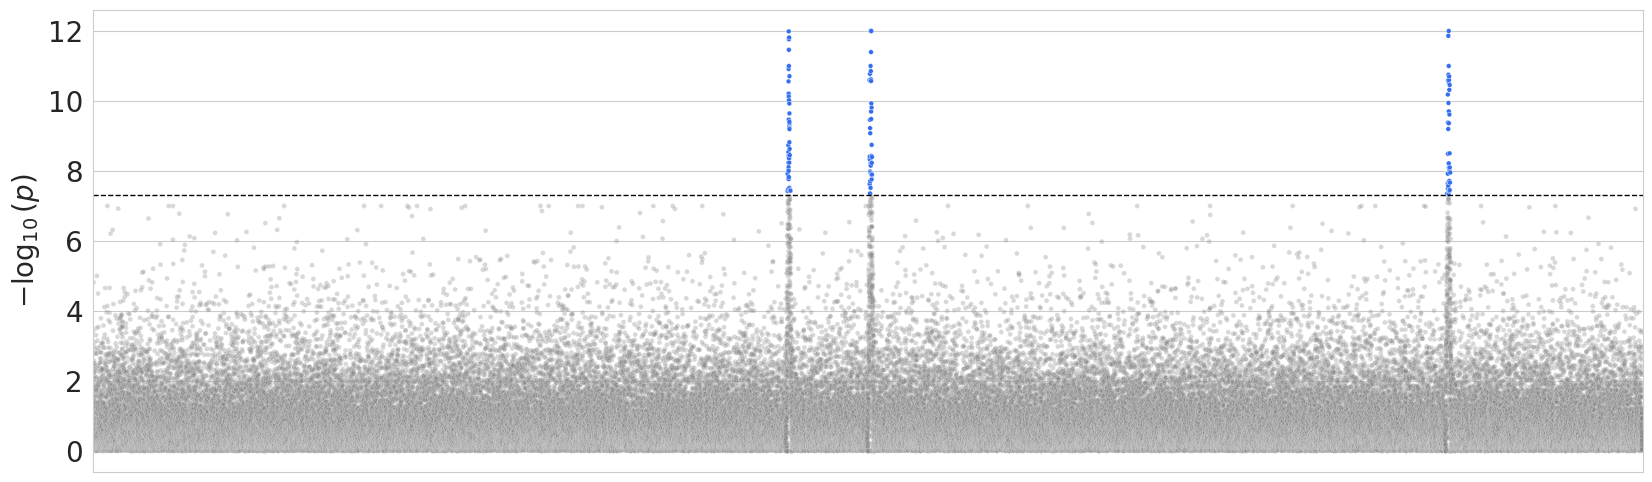

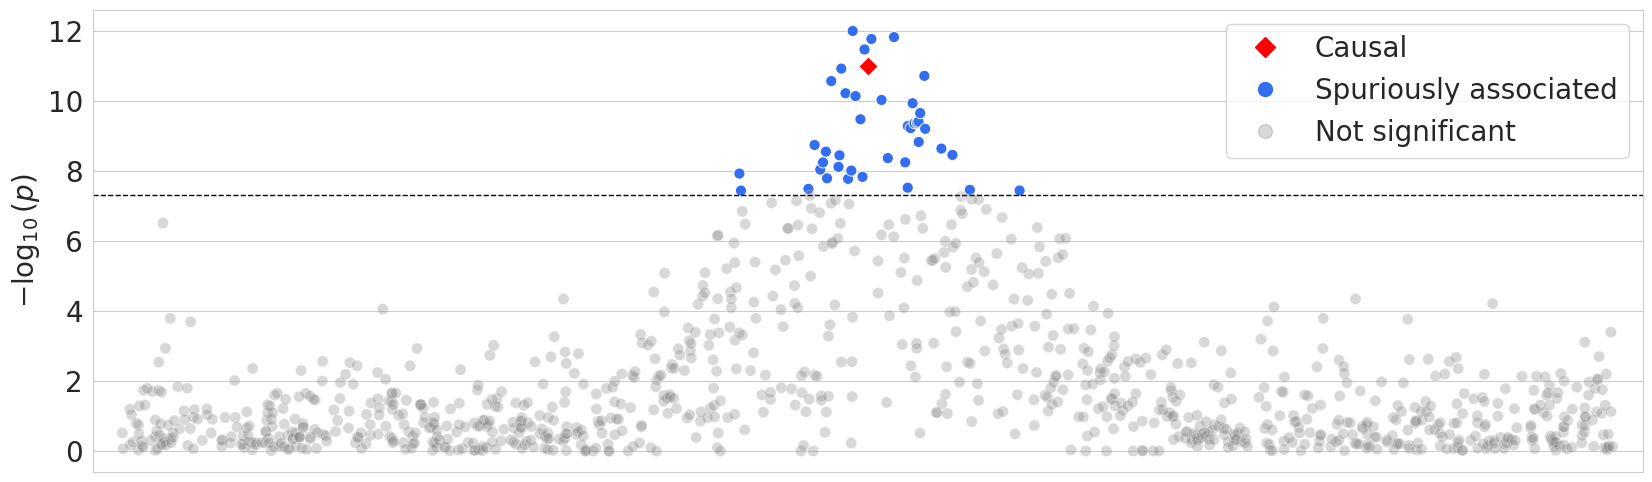

In [108]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


import warnings
warnings.filterwarnings("ignore")


def generate_fake_gwas_data(
    n_snps=100000,
    n_chromosomes=22,
    n_causal=10,
    n_neighbors=200,
    logp_decay=.001,
):
    data = []
    chrom_offsets = np.cumsum([0] + [1_000_000_000] * (n_chromosomes - 1))  # Spacing chromosomes evenly
    for chrom in range(1, n_chromosomes + 1):
        snps_per_chrom = n_snps // n_chromosomes
        positions = np.sort(np.random.randint(1, 1_000_000_000, size=snps_per_chrom)) + chrom_offsets[chrom - 1]
        p_values = np.random.uniform(0, 1, size=snps_per_chrom) ** 2  # Bias towards small p-values
        data.append(pd.DataFrame({
            'chromosome': chrom,
            'position': positions,
            '-log10p': np.clip(-np.log10(p_values), a_min=0, a_max=7)
        }))
    df = pd.concat(data).reset_index()
    df['causal'] = False
    
    idxs_causal = np.random.choice(np.arange(len(df)), n_causal)
    for idx in idxs_causal:
        val = np.random.randint(10, 12)
        df.at[idx, '-log10p'] = val
        df.at[idx, 'causal'] = True
        for offset in np.arange(-n_neighbors, n_neighbors):
            if offset == 0:
                continue
            offset_perc = np.max(1 - np.abs(offset) * logp_decay, 0)
            if offset_perc > 0:
                log10p = np.random.randint(1, int(val * offset_perc) + 2)
                log10p = log10p + np.random.normal(0, 1)
                df.at[idx + offset, '-log10p'] = log10p
    df['-log10p'].clip(lower=0, upper=12, inplace=True)
    
    return df.fillna(0)


def plot_manhattan(
    df,
    s=8,
    plot_causal=False,
):
    plt.figure(figsize=figsize)
    colors = [
        'black',
        'gray',
        '#326eef',
#         '#f26a7a',
    ]  # Alternating colors for chromosomes and significant SNPs
    df['color'] = df.apply(
        lambda row: colors[int(row['chromosome'] % 2 if row['-log10p'] < -np.log10(5e-8) else 2)],
        axis=1,
    )
    alpha = 0.3
    df['alpha'] = df.apply(
        lambda row: alpha if row['-log10p'] < -np.log10(5e-8) else 1,
        axis=1,
    )
    
    xlabel_ticks = []
    for chrom in df['chromosome'].unique():
        if plot_causal:
            chrom_data = df[
                (df['chromosome'] == chrom)
                & (df['causal'] == False)
            ]
            chrom_data_causal = df[
                (df['chromosome'] == chrom)
                & (df['causal'] == True)
            ]
            sns.scatterplot(
                x=chrom_data['position'],
                y=chrom_data['-log10p'], 
                c=chrom_data['color'], 
                alpha=chrom_data['alpha'],
                s=s,
            )

            sns.scatterplot(
                x=chrom_data_causal['position'],
                y=chrom_data_causal['-log10p'], 
                c='red', 
                s=s * 1.5,
                marker='D',
            )
            
            handles, labels = plt.gca().get_legend_handles_labels()
            
            handles.extend([
                Line2D([0], [0], label='Causal', marker='D', markersize=10, 
                     color='red', linestyle=''),
                Line2D([0], [0], label='Spuriously associated', marker='o', markersize=10, 
                     color='#326eef', linestyle=''),
                Line2D([0], [0], label='Not significant', marker='o', markersize=10, 
                     color='gray', linestyle='', alpha=.3),
            ])

            plt.legend(handles=handles)
            
        else:
            chrom_data = df[
                (df['chromosome'] == chrom)
            ]
            sns.scatterplot(
                x=chrom_data['position'],
                y=chrom_data['-log10p'], 
                c=chrom_data['color'], 
                alpha=chrom_data['alpha'],
                s=s,
            )  
        
        xlabel_ticks.append(chrom_data['position'].min())
    
    x_offset = 200_000
    plt.xlim(df['position'].min() - x_offset, df['position'].max() + x_offset)
    plt.xticks([])
    plt.xlabel(None)
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1, label='Genome-wide significance')
    plt.ylabel('$-\log_{10}(p)$')
    plt.show()


np.random.seed(2)

for _ in range(2):
    df_fake = generate_fake_gwas_data(
        n_snps=100_000,
        n_chromosomes=1,
        logp_decay=.005,
        n_causal=3,
    )

    dist = 5_000_000
    first_causal = df_fake.query('causal == True').iloc[0]
    df_tower = df_fake.loc[
        (df_fake['chromosome'] == first_causal['chromosome'])
        & (df_fake['position'].between(first_causal['position'] - dist, first_causal['position'] + dist))
    ]

    with sns.axes_style("whitegrid"):
        plot_manhattan(
            df_fake,
            s=12,
        )
        plot_manhattan(
            df_tower,
            s=64,
            plot_causal=True,
        )